## Field composite 

Calculate the El Niño composite field, and display only significant values.

### Set environment

In [1]:
#--- Libraries
import matplotlib.pyplot as plt      # plotting package
from subprocess import call          # access system commands
import seaborn as sns                # plotting aestetics
import netCDF4 as nc                 # package to read NetCDF files
import pandas as pd                  # packages for statistics
import numpy as np                   # packages for linear algebra
import itertools                     # package to create pair combinations
import glob                          # commands to access multiple files

from mpl_toolkits.axes_grid1 import ImageGrid       # plot setting libraries
from collections import OrderedDict                 # dictionaries with fixed sequence of entries
from mpl_toolkits.basemap import Basemap            # map making libraries
from cdo import *                                   # access external NetCDF data processing routines
cdo = Cdo()                          

%matplotlib inline

In [2]:
#--- Arrange data
# load precip data files
ncfile_anom_full   = nc.Dataset('data/precip.mon.mean.safr.anom.nc')
ncfile_anom_elnino = nc.Dataset('data/precip.mon.mean.safr.anom.elnino.nc')

# get coordinates of data
lons = ncfile_anom_full.variables['lon'][:]
lats = ncfile_anom_full.variables['lat'][:]
# find grid spacing
gspace_lon = np.diff(lons)[0]
gspace_lat = np.diff(lats)[0]
# add extra point for grid fill
lons = np.append(lons,lons[-1]+gspace_lon)
lats = np.append(lats,lats[-1]-gspace_lat)
# set coordinates list as grid of locations
lons, lats = np.meshgrid(lons,lats)
# shift so that lines show grid box boundaries, 
#    rather than grid point locations
lons = lons - (gspace_lon/2)
lats = lats + (gspace_lat/2)


# load El Niño dates
mei_elnino_dates = pd.read_pickle('data/mei_elnino_dates.pkl')
# only consider El Nino dates in range of precipitation estimate
mei_elnino_dates = mei_elnino_dates[mei_elnino_dates > '1978']
mei_elnino_dates = mei_elnino_dates[mei_elnino_dates < '2015-10-01']

### Calculate composite statistics 

_These estimates are done only for the mean, rather than for the median or mode. There is no_ `CDO` _opporator for the latter two statistics, so would have to change the script a bit to run the procedure for those two statistics. Probably the most interesting thing to try would be to look at the significance of estimates for the mode, when masking values below the suggested error thresholds. Then can consider each grid cell to have different degress of freedom, and so better constrain the estimate to where there is viable data._

In [ ]:
#--- Calculate mean
_ = cdo.timmean(input='data/precip.mon.mean.safr.anom.elnino.nc',
                output='data/comp.nc')

In [ ]:
#--- Significance testing
# find number of time steps in full data set
nts = len(ncfile_anom_full.variables['time'])
# find number of time steps in El Niño subset
deg_free = len(mei_elnino_dates)
# create 1000 null-tests
for samp in range(1000) :
    # random sample 
    rts = random.sample(np.arange(nts)+1,deg_free)
    rts.sort()
    rts = [str(i) for i in rts]
    # select individual fields
    cdo.seltimestep(','.join(rts),
                    input='data/precip.mon.mean.safr.anom.nc',
                    output='data/samps.nc')
    # create a composite
    cdo.timmean(input='data/samps.nc',
                output='data/nullcomp'+('%03d' % samp)+'.nc')
    # sweep up
    call('rm data/samps.nc',shell=True)
# merge composites
comps = glob.glob('data/nullcomp*.nc')
cdo.cat(input=' '.join(comps),output='data/nullcomps.nc')
# sweep up
call('rm '+' '.join(comps),shell=True)
# calculate quantiles
_ = cdo.timmin(input='data/nullcomps.nc',output='data/nullcomps.min.nc')
_ = cdo.timmax(input='data/nullcomps.nc',output='data/nullcomps.max.nc')
_ = cdo.timpctl('97.5',
                input='data/nullcomps.nc data/nullcomps.min.nc data/nullcomps.max.nc',
                output='data/anom.np975.nc')
_ = cdo.timpctl('2.5',
                input='data/nullcomps.nc data/nullcomps.min.nc data/nullcomps.max.nc',
                output='data/anom.np025.nc')
call('rm data/nullcomps.nc data/nullcomps.min.nc data/nullcomps.max.nc',shell=True)


In [ ]:
#--- Create mask for non signficant grid cells
# values above the cut off to be significant negative values
_ = cdo.gt(input='data/comp.nc data/anom.np025.nc',
           output='data/over.nc')
# values below the cut off to be significant positive values
_ = cdo.lt(input='data/comp.nc data/anom.np975.nc',
           output='data/under.nc')
# combine results
_ = cdo.add(input='data/under.nc data/over.nc',
            output='data/under_and_over.nc',options='-b 64')
# only consider where both disqualfying criteria are met
_ = cdo.gec('1.5',input='data/under_and_over.nc',
            output='data/nsig.nc')

### Map results

In [3]:
# link to composite file
ncfile_comp = nc.Dataset('data/comp.nc')
# link to  mask file
ncfile_mask = nc.Dataset('data/nsig.nc')

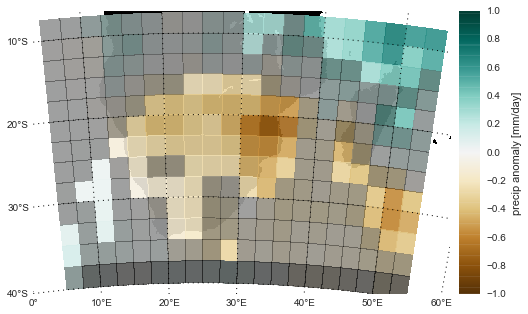

In [4]:
# create figure
fig, chart = plt.subplots(1,figsize=(8,8))
# set region/projection
_ = chart = Basemap(projection='lcc',resolution='c',
                    lat_0=-17,lon_0=25,
                    llcrnrlat=-40,urcrnrlat=-5.,
                    llcrnrlon=0,urcrnrlon=55) 
# mark land mass
_ = chart.drawlsmask(land_color='black') 
# draw parallels and meridians
_ = chart.drawparallels(np.arange(-90.,91.,10.),labels=[True,False,False,False],dashes=[1,4])
_ = chart.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[1,4])
# read composite
comp = np.copy(ncfile_comp.variables['precip'][0,:,:])
# overlay composite
sm = chart.pcolormesh(lons,lats,comp,shading='flat',latlon=True,
                      alpha=0.9,cmap='BrBG',vmin=-1,vmax=1)
# add color bar
cb = chart.colorbar()
cb.set_label('precip anomaly [mm/day]')
# read mask file
mask = np.copy(ncfile_mask.variables['precip'][0,:,:])
# only consider values where mask=True
mask = np.ma.masked_where(mask < 0.2,mask)
# shade out anomalies below estimated error range
ms = chart.pcolormesh(lons,lats,mask,
                      shading='flat',latlon=True,
                      alpha=0.35,cmap='Greys',vmin=0,vmax=1)

plt.savefig('comp_sigmasked.png')

If the blanking out makes the image difficult to read, there is also the option of just not plotting the 'insignificant' values.

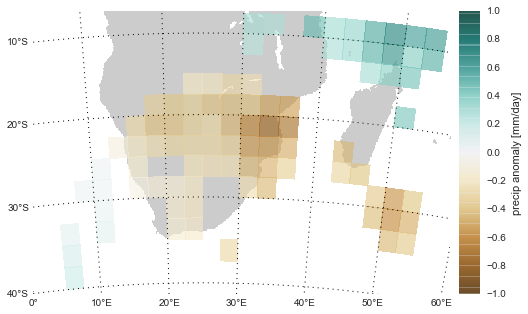

In [5]:
# create figure
fig, chart = plt.subplots(1,figsize=(8,8))
# set region/projection
_ = chart = Basemap(projection='lcc',resolution='c',
                    lat_0=-17,lon_0=25,
                    llcrnrlat=-40,urcrnrlat=-5.,
                    llcrnrlon=0,urcrnrlon=55) 
# mark land mass
_ = chart.drawlsmask() 
# draw parallels and meridians
_ = chart.drawparallels(np.arange(-90.,91.,10.),labels=[True,False,False,False],dashes=[1,4])
_ = chart.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[1,4])
# read composite
comp = np.copy(ncfile_comp.variables['precip'][0,:,:])
# read mask file
mask = np.copy(ncfile_mask.variables['precip'][0,:,:])
# only consider values where mask=True
comp = np.ma.masked_where(mask > 0.2,comp)
# overlay composite
sm = chart.pcolormesh(lons,lats,comp,shading='flat',latlon=True,
                      alpha=0.6,cmap='BrBG',vmin=-1,vmax=1)
# add color bar
cb = chart.colorbar()
cb.set_label('precip anomaly [mm/day]')
